In [1]:
from monai.data import ArrayDataset, DataLoader, PILReader

In [2]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections.abc import Callable

from monai.transforms import ToTensor

from data_utils import *
from VGGLoss import *
from Generator import *
from Discriminator import *

In [8]:
class TestHandler():
    def __init__(self,
                 patch_iterator: torch.utils.data.IterableDataset,
                 model: GeneratorUnet,
                 model_checkpoint: str=None,
                 output_dir: str="./output",
                ) -> None:
        self.patch_iterator = patch_iterator
        self.output_dir = output_dir
        
#         self.model_args = model_args 
        self.model_checkpoint = model_checkpoint
#         self.model_constructor = model_constructor
        self.device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
        
#         self.model = model_constructor(**model_args) if model_args is not None else model_constructor()
#         self.model = self.model.to(self.device)
        self.model = model.to(self.device)
        self.model.eval()
#         try:
        print(f'Loading checkpoint: {self.model_checkpoint}')
        chkp = torch.load(self.model_checkpoint)
        self.model.load_state_dict(chkp["model_state_dict"])
#         except:
#             print("The Checkpoint cannot loaded. Check the given path:\n",
#                   model_checkpoint)
#             return
    
    def generate_patch_iterator(self, image_list):
        for img_tuple in image_list:
            dir_name, fname = img_tuple[0].split("/")[-2:]
            img_prefix = fname[:-16]
            dataset = self.patch_iterator(data=img_tuple,
                                          patch_size=256,
                                          overlap_ratio=0.5,
                                          data_reader=PILReader())
            data_loader = DataLoader(dataset,
                                     batch_size=8,
                                     shuffle=False)
            yield dir_name, img_prefix, data_loader

    def run_test(self, image_list):
        with torch.no_grad():
            for dir_name, img_prefix, data_loader in tqdm(self.generate_patch_iterator(image_list),
                                                             total=len(image_list),
                                                             file=sys.stdout):
                patchesC01, patchesC02, patchesC03 = [], [], []
                for batch_index, batch in enumerate(data_loader):
                    # unpack the inputs
                    inpZ01, inpZ02, inpZ03, inpZ04, inpZ05, inpZ06, inpZ07 = \
                        batch[:,:,0,:,:].to(self.device), \
                        batch[:,:,1,:,:].to(self.device), \
                        batch[:,:,2,:,:].to(self.device), \
                        batch[:,:,3,:,:].to(self.device), \
                        batch[:,:,4,:,:].to(self.device), \
                        batch[:,:,5,:,:].to(self.device), \
                        batch[:,:,6,:,:].to(self.device)
                    # unpack the targets
                    targetC01, targetC02, targetC03 = batch[:,:,7,:,:].to(self.device), \
                        batch[:,:,8,:,:].to(self.device), \
                        batch[:,:,9,:,:].to(self.device)
                    # predict with model
                    outC01, outC02, outC03 = self.model(inpZ01, inpZ02, inpZ03, 
                                                        inpZ04, inpZ05, inpZ06, inpZ07)
                    
                    outC01, outC02, outC03 = [p[0] for p in outC01.data.cpu()], \
                                             [p[0] for p in outC02.data.cpu()], \
                                             [p[0] for p in outC03.data.cpu()]
                    # TODO: compute loss/metric 
                    # TODO: Create a good functions of losses if it is possible!
                    # 
#                     return outC01
                    patchesC01.extend(outC01)
                    patchesC02.extend(outC02)
                    patchesC03.extend(outC03)
                # (3,256,256)
                for i, patches in enumerate([patchesC01, patchesC02, patchesC03]):
                    print(len(patches))
                    print(patches[0].shape)
                    merged_img = data_loader.dataset.merge_patches(patches)
                    # transform back to 16bits. Applied transformation in the training:
                    # vol = (np.log(1 + input_) - 5.5)/5.5
#                     merged_img = np.exp(merged_img * 5.5 + 5.5) - 1
                    out_dir = os.path.join(self.output_dir, dir_name)
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    self.save_img(merged_img, 
                                  os.path.join(out_dir,
                                               f"{img_prefix}L01A0{i+1}Z01C0{i+1}.tif"))
                
                
    @staticmethod
    def save_img(img,
                 output_path):
        # write 16-bit TIFF image
        if type(img) != np.ndarray:
            img = np.ndarray(img)
        # PIL interprets mode 'I;16' as "uint16, little-endian"
        img_out = Image.new('I;16', img.shape)
        # make sure u16in little-endian, output bytes
        outpil = img.astype(img.dtype.newbyteorder("<")).tobytes()
        # save it with the img_out
        img_out.frombytes(outpil)
        img_out.save(output_path)

In [9]:
model = GeneratorUnet()
model_chkp_path = "checkpoints/THEBESTOFTHEBEST/G_epoch_62.pth"
patch_iterator = OverlappyGridyDataset

In [10]:
test_handler = TestHandler(patch_iterator,
                           model=model,
                           model_checkpoint=model_chkp_path)

Loading checkpoint: checkpoints/THEBESTOFTHEBEST/G_epoch_62.pth


In [11]:
img_tuple = [('/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
             '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')
]
smt = test_handler.run_test(img_tuple)

  0%|          | 0/1 [00:00<?, ?it/s]340
torch.Size([256, 256])
340
torch.Size([256, 256])
340
torch.Size([256, 256])
100%|██████████| 1/1 [00:11<00:00, 11.37s/it]


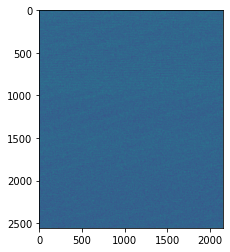

In [12]:
import matplotlib.pyplot as plt
p = "output/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif"
img = plt.imread(p)
img = np.array(img)
plt.imshow(img)

In [30]:
img

array([[19546, 62004, 44971, ..., 16515, 25654, 50006],
       [65269, 16517, 57757, ..., 13794, 29905, 16513],
       [34171, 52092, 32029, ..., 16519, 61069, 12562],
       ...,
       [11963, 16511, 27617, ..., 35538, 62543, 16466],
       [12192,  5255,   162, ..., 16444, 17590, 61088],
       [39927, 16442, 41651, ..., 52108, 61555, 16466]], dtype=uint16)

In [32]:
img = (np.log(1 + img) - 5.5)/5.5

invalid value encountered in log


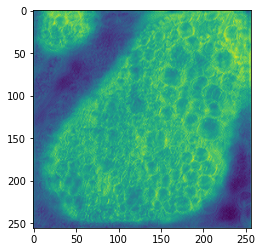

In [50]:
plt.imshow(smt[3])